# 1D Spectrum Analysis HAP_hd

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [52]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import (
    MapDataset, 
    Datasets, 
    FluxPointsDataset,
    SpectrumDataset
)
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    BrokenPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [29]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [30]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-hd")
path.mkdir(exist_ok=True)

pathm = path/"mapdatasets1D"
pathm.mkdir(exist_ok=True)

pathres = path/"spectra"
pathres.mkdir(exist_ok=True)

# Collecting data and sorting observations

In [31]:
data_store_hess1 = DataStore.from_dir("$GAMMAPY_DATA/hap-hd_Prod05/hess1/std_ImPACT_fullEnclosure")
data_store_hess1u = DataStore.from_dir("$GAMMAPY_DATA/hap-hd_Prod05/hess1u/std_ImPACT_fullEnclosure")
data_store_hess2 = DataStore.from_dir("$GAMMAPY_DATA/hap-hd_Prod05/hess2/std_ImPACT_fullEnclosure")

In [32]:
# Sky region selection : observation pointing within this region will be selected 
#(this can be redundant with maximum offset selection, but using the max_offset should be prefered)

from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(1.0, 'deg'),
                 border=Angle(0, 'deg'))


# selecting the admitted range of zenithal angle, such selection can be done for any column of the obs_table
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=[0., 50])

obs_table1 = data_store_hess1.obs_table.select_observations(selection)
obs_table1 = obs_table1.select_observations(selectionZEN)

obs_table1u = data_store_hess1u.obs_table.select_observations(selection)
obs_table1u = obs_table1u.select_observations(selectionZEN)

obs_table2 = data_store_hess2.obs_table.select_observations(selection)
obs_table2 = obs_table2.select_observations(selectionZEN)

In [33]:
#HESS1
ids1 = obs_table1["OBS_ID"] 
observations1 = data_store_hess1.get_observations(ids1, skip_missing=True)

#HESS1U
ids2 = obs_table1u["OBS_ID"]
observations1u = data_store_hess1u.get_observations(ids2, skip_missing=True)

# HESS2
ids1u = obs_table2["OBS_ID"]
observations2 = data_store_hess2.get_observations(ids1u, skip_missing=True)

In [34]:
#time intervals used for selection

t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}


In [35]:
# HESS1
yearly_obs1 = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table1.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store_hess1.get_observations(ids, skip_missing=True)
    yearly_obs1[year] = observations_year

#HESS1U    
yearly_obs1u = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table1u.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store_hess1u.get_observations(ids, skip_missing=True)
    yearly_obs1u[year] = observations_year

#HESS2    
yearly_obs2 = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table2.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store_hess2.get_observations(ids, skip_missing=True)
    yearly_obs2[year] = observations_year

## Setting the parameters of the analysis

In [36]:
# Defining the "on" region over which the spectrum will be computed

on_region_radius = Angle("0.1 deg")
on_region = CircleSkyRegion(center=src_pos, radius=on_region_radius)

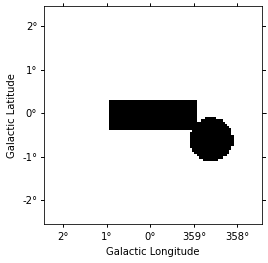

In [37]:
# We need to define an "off" region as well, to estimate the background level

exclusion_region = RectangleSkyRegion(src_pos, 2*u.deg, 0.7*u.deg) #réduire en latitude
skydir = src_pos.galactic

# à rajouter au masque
J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)


exclusion_mask = Map.create(
    npix=(100, 100), binsz=0.05, skydir=skydir, proj="TAN", frame='galactic'
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)*exclusion_mask.geom.region_mask([J1745_303_region] , inside=False)
exclusion_mask.data = mask
exclusion_mask.plot();

In [38]:
e_reco = MapAxis.from_energy_bounds(0.1, 50, 20, unit="TeV", name="energy")
e_true = MapAxis.from_energy_bounds(
    0.05, 100, 200, unit="TeV", name="energy_true"
)
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

## Constructing the datasets

In [39]:
%%time

# constructing datasets for every year of observations, for HESS1, HESS2, HESS1U and the "total" one

datasets = []
datasetsHESS1 = []
datasetsHESS1U = []
datasetsHESS2 = []
year_datasets = dict()

# there was an option to call the datasets like the obs-id, but somehow some runs end up with the "same name", and then the Datasets can't be treated

for year in range(2004,2005):
    year_datasets[year] = []
    for obs_id, obs in zip(ids1, yearly_obs1[year]):
        dataset = dataset_maker.run(dataset_empty.copy(), obs) 
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        
        if not dataset_on_off.counts_off is None :
            year_datasets[year].append(dataset_on_off)
            datasetsHESS1.append(dataset_on_off)
            datasets.append(dataset_on_off)
        
    for obs_id, obs in zip(ids2, yearly_obs2[year]):
        dataset = dataset_maker.run(dataset_empty.copy(), obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        
        if not dataset_on_off.counts_off is None :
            year_datasets[year].append(dataset_on_off)
            datasetsHESS2.append(dataset_on_off)
            datasets.append(dataset_on_off)
        
    for obs_id, obs in zip(ids1u, yearly_obs1u[year]):
        dataset = dataset_maker.run(dataset_empty.copy(), obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        
        if not dataset_on_off.counts_off is None :
            year_datasets[year].append(dataset_on_off)
            datasetsHESS1U.append(dataset_on_off)
            datasets.append(dataset_on_off)

CPU times: user 47.4 s, sys: 222 ms, total: 47.6 s
Wall time: 47.8 s


# Analysis

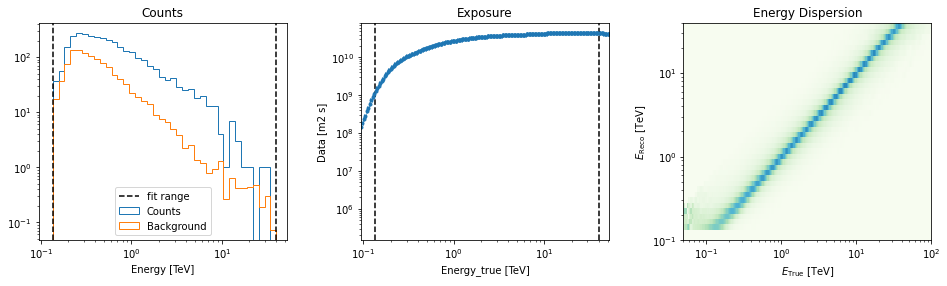

In [15]:
datasets_stacked = Datasets(datasets).stack_reduce()
datasets_stacked.peek()
plt.savefig(pathres/"stacked_peek.pdf")

## Fitting without stacking

In [16]:
spectral_model = ExpCutoffPowerLawSpectralModel(index=2, amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV , lambda_= 1/(10*u.TeV) , alpha= 1)

In [17]:
spectral_model.parameters['index'].frozen = True
spectral_model.parameters['lambda_'].frozen = True

In [18]:
print(spectral_model)

ExpCutoffPowerLawSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 2.0000e+00                nan nan   True 0.000e+00
amplitude 3.0000e-12 cm-2 s-1 TeV-1 nan nan  False 0.000e+00
reference 1.0000e+00            TeV nan nan   True 0.000e+00
  lambda_ 1.0000e-01          TeV-1 nan nan   True 0.000e+00
    alpha 1.0000e+00                nan nan   True 0.000e+00


In [53]:
#spectral_model = PowerLawSpectralModel(index=2, amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV )

spectral_model = BrokenPowerLawSpectralModel(index1=2, index2=3, amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV )

In [54]:
model_joint = SkyModel(spectral_model=spectral_model, name='model_joint')

#maskfit = datasets[0].counts.energy_mask(0.7*u.TeV, 40*u.TeV)

for dataset in datasets:
    dataset.models = model_joint
    #dataset.mask_fit = maskfit

fit_joint = Fit(datasets)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model_joint.copy()

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: ov

In [55]:
result_joint

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 28
	total stat : 3892.48

## Fitting after stacking

In [43]:
model_stack = SkyModel(spectral_model=spectral_model.copy(), name='model_stack')

#maskfit = datasets_stacked.counts.energy_mask(0.7*u.TeV, 40*u.TeV)

datasets_stacked.models = model_stack
#datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()


In [26]:
datasets_stacked.psf

## Comparing the two fits

In [45]:
model_best_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.2298e+00,,nan,nan,False,2.639e-02
amplitude,2.0869e-12,cm-2 s-1 TeV-1,nan,nan,False,6.003e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [46]:
model_best_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.2330e+00,,nan,nan,False,2.558e-02
amplitude,2.1217e-12,cm-2 s-1 TeV-1,nan,nan,False,5.977e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [47]:
def plot_spectrum(modelstack, modeljoint, path ,namefile, name):
    plt.figure(figsize=(10,7))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## joint
    index = modeljoint.spectral_model.parameters["index"].value
    amp = modeljoint.spectral_model.parameters["amplitude"].value
    
    if False:#modeljoint.spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/modeljoint.spectral_model.parameters["lambda_"].value
        modeljoint.spectral_model.plot(
        **plot_kwargs, label=r"joint  : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff))
    else :  
        modeljoint.spectral_model.plot(
        **plot_kwargs, label=r"joint  : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    modeljoint.spectral_model.plot_error(**plot_kwargs)

    
    ## stacked
    index = modelstack.spectral_model.parameters["index"].value
    amp = modelstack.spectral_model.parameters["amplitude"].value
    
    if False:#modelstack.spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/modelstack.spectral_model.parameters["lambda_"].value
        modelstack.spectral_model.plot(
        **plot_kwargs, label=r"stacked: index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff ))
    else :  
        modelstack.spectral_model.plot(
        **plot_kwargs, label=r"stacked: index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    modelstack.spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    plt.savefig(path/namefile)

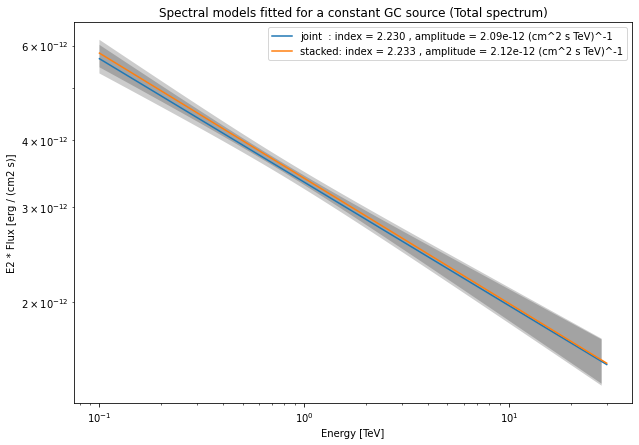

In [48]:
plot_spectrum(model_best_stacked, model_best_joint, pathres, "models_total.pdf", "Total spectrum")

In [ ]:
def plot_1Dfit(dataset, method='diff'):
        from matplotlib.gridspec import GridSpec
        gs = GridSpec(7, 1)

        ax_spectrum = plt.subplot(gs[:5, :])
        ax = ax_spectrum
        # plus de npred_sig
        
        dataset.npred_sig().plot(ax=ax, label="mu_src", energy_unit=dataset._e_unit)
        dataset.excess.plot(ax=ax, label="Excess", fmt=".", energy_unit=dataset._e_unit)

        e_min, e_max = dataset.energy_range
        kwargs = {"color": "black", "linestyle": "dashed"}
        ax.axvline(e_min.to_value(dataset._e_unit), label="fit range", **kwargs)
        ax.axvline(e_max.to_value(dataset._e_unit), **kwargs)

        ax.legend(numpoints=1)
        ax.set_title("")

        ax.set_xticks([])

        ax_residuals = plt.subplot(gs[5:, :])
        dataset.plot_residuals( method, ax=ax_residuals)
        return ax, ax_residuals

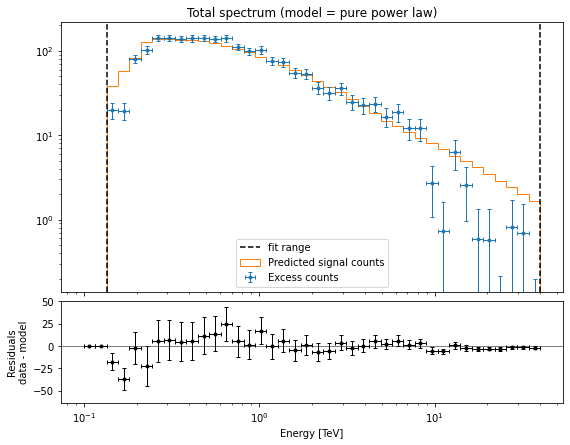

In [49]:
plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = datasets_stacked.plot_fit()

ax_spectrum.set_title("Total spectrum (model = pure power law)")
plt.savefig(pathres/"total_spectrum_stacked.pdf")

## Computing Flux points

In [ ]:
e_min, e_max = 0.5, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [ ]:
fpe = FluxPointsEstimator(datasets=[datasets_stacked], e_edges=e_edges)
flux_points = fpe.run()

In [ ]:

plt.figure(figsize=(8, 5))
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

plt.savefig(path1/"fluxpoints.pdf")

In [ ]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_stacked
)

In [ ]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek()
plt.savefig(path1/"fluxpoints_v_model.pdf")

## Studying HESS1 HESS2 and HESS1U separately

In [ ]:
datasets_stacked = Datasets(datasetsHESS1).stack_reduce()

model_stack = SkyModel(spectral_model=spectral_model)

datasets_stacked.models = model_stack # quelle différence entre model et models ?
#datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

#model_best_stacked.parameters.to_table()

plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = plot_1Dfit(datasets_stacked)
ax_spectrum.set_title("HESS1 spectrum")
plt.savefig(path1/'HESS1spectrum.pdf')

In [ ]:
datasets_stacked = Datasets(datasetsHESS2).stack_reduce()


model_stack = SkyModel(spectral_model=spectral_model)

datasets_stacked.models = model_stack # quelle différence entre model et models ?
#datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

#model_best_stacked.parameters.to_table()

plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = plot_1Dfit(datasets_stacked)
ax_spectrum.set_title("HESS2 spectrum")
plt.savefig(path1/'HESS2spectrum.pdf')

In [ ]:
datasets_stacked = Datasets(datasetsHESS1U).stack_reduce()

model_stack = SkyModel(spectral_model=spectral_model)

datasets_stacked.models = model_stack # quelle différence entre model et models ?
#datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

#model_best_stacked.parameters.to_table()

plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = plot_1Dfit(datasets_stacked)
ax_spectrum.set_title("HESS1U spectrum")
plt.savefig(path1/'HESS1Uspectrum.pdf')

## Studying each each year separately

In [ ]:
models_year = dict()

# problème ici

years = []
for year in range(2004,2020):
    if year_datasets[year] != []:
        years.append(year)

        
for year in years:
    datasets_stacked = Datasets(year_datasets[year]).stack_reduce()

    model_stack = SkyModel(spectral_model=spectral_model)

    datasets_stacked.models = model_stack # quelle différence entre model et models ?
    #datasets_stacked.mask_fit = maskfit

    stacked_fit = Fit([datasets_stacked])
    result_stacked = stacked_fit.run()

    # make a copy to compare later
    model_best_stacked = model_stack.copy()
    models_year[year] = model_best_stacked

    plt.figure(figsize=(9, 7))
    ax_spectrum, ax_residual = plot_1Dfit(datasets_stacked)
    ax_spectrum.set_title(str(year) + " spectrum")
    name = str(year) + "spectrum.pdf"
    plt.savefig(path1/name)